<a href="https://colab.research.google.com/github/qkrwoghd04/Image-text_fusion_for_binary_classification_using_BERT-ViT/blob/master/code/Image%26Text_fusion_using_vit_b16_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install BERT for tf2 module
!pip install bert-for-tf2
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 817.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30510 sha256=e5569aad0d73ae7eca701821af0de108340b7e07d46e798c7803692ffff64fb5
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19455 sha256=b1ee249feecfa8c3b74df2146dfcba969a2f1aa5d4fb564cd4ed29f586451feb
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=5ab733dcf1d7fc5c1e7e6333215a77c4d8584a41b378cc16a4d38e7fbf81362f
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e9087

In [ ]:
%tensorflow_version 2.x
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from keras.models import Model
import keras
from keras import layers
import keras as keras
import cv2
from keras.callbacks import CSVLogger
import sys
import time
import pickle
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras import callbacks


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# 데이터 경로 및 파라미터 설정
train_data_dir = r'/content/drive/MyDrive/image_dataset/processed/train'
test_data_dir = r'/content/drive/MyDrive/image_dataset_splited/test'
nb_train_samples = 400
nb_test_samples = 40
n_classes = 2
epochs = 20
batch_size = 16
# 이미지와 패치 크기 설정
input_shape= (224,224,3)
image_size = 224
patch_size = 32
num_patches = (image_size//patch_size)**2
learning_rate = 1e-4

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 증강을 위한 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 픽셀 값을 [0, 1] 범위로 스케일링
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 검증 데이터로 사용할 비율을 설정
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# 훈련 및 검증 데이터 로딩
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # 훈련 데이터로 사용
)

# 검증 데이터 로더 생성
val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # 검증 데이터로 사용
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary'
)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
# TensorFlow Hub에서 Vision Transformer 모델 로드
vit_model = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_classification/1", trainable=True)

# 입력 레이어
inputs = tf.keras.Input(shape=(224, 224, 3))

# Vision Transformer 모델 레이어
vit_outputs = vit_model(inputs)

# 추가적인 Dense 및 Dropout 레이어
x = layers.Dense(128, activation='relu', name='Dense_128')(vit_outputs)
x = layers.Dropout(0.5, name='dropout_1')(x)
x = layers.Dense(64, activation='relu', name='Dense_64')(x)
x = layers.Dropout(0.5, name='dropout_2')(x)

# 최종 분류 레이어
num_classes = 2
outputs = layers.Dense(num_classes, activation='softmax', name='classifier')(x)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# 모델 요약 정보 출력
model.summary()


ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_13 (KerasLayer  (None, 1000)              86567656  
 )                                                               
                                                                 
 Dense_128 (Dense)           (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                          

In [ ]:
# 모델 컴파일
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.004)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 체크포인트 콜백 활성화
checkpoint_filepath = "/content/drive/MyDrive/tmp/checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

# reduce_lr = callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, early_stopping]  # 체크포인트 콜백 추가
)

Epoch 1/20
20/20 [==============================] - 21s 878ms/step - loss: 2.2469 - accuracy: 0.5188 - val_loss: 0.6084 - val_accuracy: 0.6875
Epoch 2/20
20/20 [==============================] - 11s 543ms/step - loss: 1.6360 - accuracy: 0.5406 - val_loss: 0.3132 - val_accuracy: 0.8875
Epoch 3/20
20/20 [==============================] - 11s 555ms/step - loss: 1.2992 - accuracy: 0.6156 - val_loss: 0.1849 - val_accuracy: 0.9625
Epoch 4/20
20/20 [==============================] - 13s 652ms/step - loss: 0.6688 - accuracy: 0.7469 - val_loss: 0.1137 - val_accuracy: 0.9875
Epoch 5/20
20/20 [==============================] - 10s 495ms/step - loss: 0.4747 - accuracy: 0.8125 - val_loss: 0.1387 - val_accuracy: 0.9750
Epoch 6/20
20/20 [==============================] - 10s 527ms/step - loss: 0.5534 - accuracy: 0.7906 - val_loss: 0.1030 - val_accuracy: 0.9875
Epoch 7/20
20/20 [==============================] - 9s 438ms/step - loss: 0.4939 - accuracy: 0.7750 - val_loss: 0.1092 - val_accuracy: 0.9625


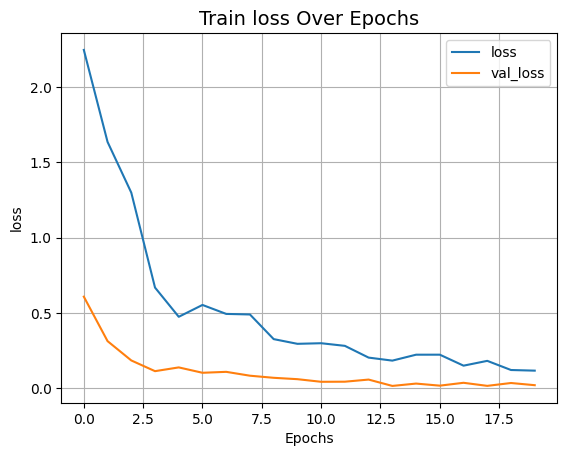

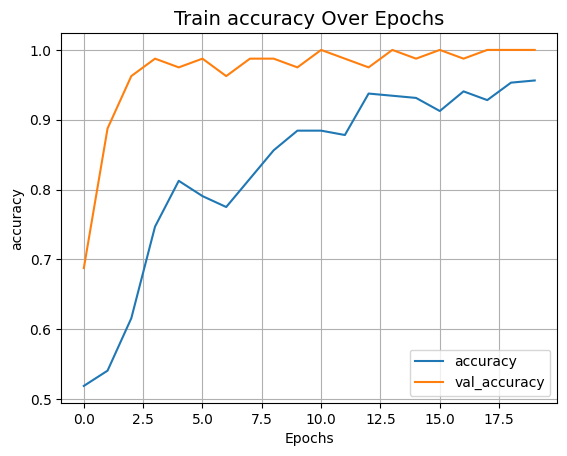

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

3/3 [==============================] - 3s 1s/step - loss: 1.1622 - accuracy: 0.7000
Test Loss: 1.1622310876846313
Test Accuracy: 0.699999988079071
